In [149]:
import json
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import numpy as np

In [150]:

# Load JSON data
with open("culture_map_data.json", "r") as f:
    culture_data = json.load(f)

with open("hofstede_data.json", "r") as f:
    hofstede_data = json.load(f)


In [151]:
   
# Extract country names and scores
countries = [item["name"] for item in hofstede_data]

scores = [item["scores"] for item in hofstede_data]

# Convert scores to a DataFrame
scores_df = pd.DataFrame(scores, index=countries).replace(-1, pd.NA).dropna(axis=1, how="any")
# Calculate variances for scaled Euclidean distance
variances = scores_df.var().values

# Calculate pairwise distances using scaled Euclidean distance
distances = pdist(scores_df, metric="seuclidean", V=variances)

# Convert distances to a squareform matrix and create a DataFrame for readability
distance_matrix = squareform(distances)
distance_df = pd.DataFrame(distance_matrix, index=countries, columns=countries)
distance_df.head()


,Africa East,Africa West,Albania,Algeria,Arab countries,Argentina,Armenia,Australia,Austria,Azerbaijan,...,Tanzania,Thailand,Trinidad and Tobago,Turkey,Ukraine,Uruguay,U.S.A.,Venezuela,Vietnam,Zambia
Africa East,0.000000,2.074514,3.090235,1.271246,1.428034,2.366963,2.489900,3.530508,3.950538,2.490558,...,0.346031,0.775907,2.353723,1.764552,3.788393,2.278916,3.489470,3.588402,1.539287,0.432066
Africa West,2.074514,0.000000,4.114317,2.389018,2.305157,2.527819,3.589806,3.743594,4.635399,3.691450,...,2.121582,2.021400,1.625483,2.635338,5.086562,2.685992,3.805985,2.103162,3.012166,2.131634
Albania,3.090235,4.114317,0.000000,3.001342,2.423823,3.766477,1.961470,4.975187,4.564080,1.886614,...,2.986834,3.366770,4.333972,2.891396,3.517877,3.752816,4.855800,4.289544,3.182058,3.319271
Algeria,1.271246,2.389018,3.001342,0.000000,1.076191,2.555059,1.984463,4.136597,4.722630,1.940140,...,1.180757,1.111766,3.123844,1.623048,3.173560,1.881614,4.135422,3.757178,2.373543,1.478943
Arab countries,1.428034,2.305157,2.423823,1.076191,0.000000,2.163124,2.113184,3.584231,4.234680,1.984162,...,1.418829,1.649498,2.870858,1.626393,3.490382,2.052952,3.567446,3.343159,2.552201,1.545873


In [164]:
from scipy.spatial.distance import pdist, squareform

def calculate_scaled_euclidean_distances(data, score_key="scores"):
    # Extract country names and scores
    countries = [item["name"] for item in data]
    scores = [item[score_key] for item in data]
    
    # Convert scores to a DataFrame
    scores_df = pd.DataFrame(scores, index=countries).replace(-1, pd.NA).dropna(axis=1, how="any")
    
    # Calculate variances for scaled Euclidean distance
    variances = scores_df.var().values
    
    # Calculate pairwise distances using scaled Euclidean distance
    distances = pdist(scores_df, metric="seuclidean", V=variances)
    
    # Convert distances to a squareform matrix and create a DataFrame for readability
    distance_matrix = squareform(distances)
    distance_df = pd.DataFrame(distance_matrix, index=countries, columns=countries)
    
    return distance_df

In [165]:
def visualize_country_network(distance_df, selected_countries=None, title="Network Graph of Country Distances"):
    """
    Visualize a network graph of country distances to scale.

    Args:
        distance_df (pd.DataFrame): A DataFrame containing the distance matrix.
        selected_countries (list): A list of country codes to include in the graph. If None, include all countries.
        title (str): Title of the graph.
    """
    # Use all countries if no selection is provided
    if selected_countries is None:
        selected_countries = distance_df.index.tolist()
    
    # Filter the distance matrix for the selected countries
    filtered_df = distance_df.loc[selected_countries, selected_countries]
    
    # Use MDS to compute positions to scale
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    positions = mds.fit_transform(filtered_df.values)
    
    # Map positions to a dictionary for NetworkX
    pos = {country: (positions[i, 0], positions[i, 1]) for i, country in enumerate(filtered_df.index)}
    
    # Create a network graph
    G = nx.Graph()
    
    # Add edges with weights
    for country1 in filtered_df.index:
        for country2 in filtered_df.columns:
            if country1 != country2:  # Avoid self-loops
                G.add_edge(country1, country2, weight=filtered_df.loc[country1, country2])
    
    # Draw the network graph
    plt.figure(figsize=(10, 7))
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="black")
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7, edge_color="black")
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="white")
    
    # Add edge labels to indicate distances
    edge_labels = nx.get_edge_attributes(G, 'weight')
    edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}  # Format weights
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    # Turn off axes for a clean look
    plt.axis("off")

    # Show the plot
    plt.title(title)
    plt.show()
    plt.savefig(title + ".png", format='png')


In [166]:
def plot_kmeans_with_highlight(distance_df, highlight_countries, n_clusters=4, title="K-Means Clustering with Highlighted Countries"):
    """
    Plot a K-Means clustering result with MDS coordinates, highlighting specific countries.

    Args:
        distance_df (pd.DataFrame): A DataFrame containing the distance matrix.
        highlight_countries (list): List of country names to highlight in the plot.
        n_clusters (int): Number of clusters for K-Means.
        title (str): Title of the plot.
    """
    # Perform MDS to reduce the distance matrix to 2D coordinates
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    mds_coordinates = mds.fit_transform(distance_df.values)
    
    # Perform K-Means clustering on the distance matrix
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(distance_df)
    
    # Scatter plot of MDS coordinates
    plt.figure(figsize=(12, 8))
    plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], c=kmeans_labels, cmap='viridis', s=100, label="Clustered Points")
    
    # Annotate and highlight specific countries
    for i, country in enumerate(distance_df.index):
        if country in highlight_countries:
            plt.scatter(
                mds_coordinates[i, 0], 
                mds_coordinates[i, 1], 
                color='red', 
                s=200, 
                edgecolor='black', 
                label=f"Highlighted: {country}" if i == 0 else None
            )
            plt.annotate(
                country, 
                (mds_coordinates[i, 0] + 0.1, mds_coordinates[i, 1] + 0.1),
                fontsize=12,
                fontweight='bold',
                color='white',
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='black')
            )
        else:
            plt.annotate(
                country,
                (mds_coordinates[i, 0] + 0.05, mds_coordinates[i, 1] + 0.05),
                fontsize=8,
                color='black'
            )
    
    # Title and labels
    plt.title(title)
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.legend()
    plt.tight_layout()
    plt.savefig(title + ".png", format='png')
    plt.show()

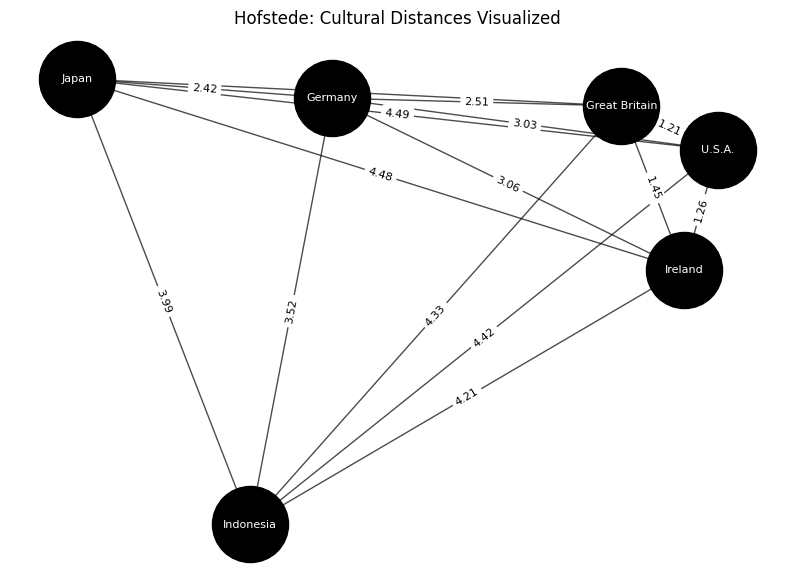

<Figure size 640x480 with 0 Axes>

In [167]:
# Load JSON data
with open("hofstede_data.json", "r") as f:
    hofstede_data = json.load(f)
# Calculate distances
distance_df = calculate_scaled_euclidean_distances(hofstede_data)
# Selected countries
selected_countries = ["Germany", "Great Britain", "Indonesia", "Ireland", "Japan", "U.S.A."]
#selected_countries = ["Germany", "UK", "Indonesia", "Ireland", "Japan", "United States"]

# Visualize the network
visualize_country_network(distance_df, selected_countries, title="Hofstede: Cultural Distances Visualized")

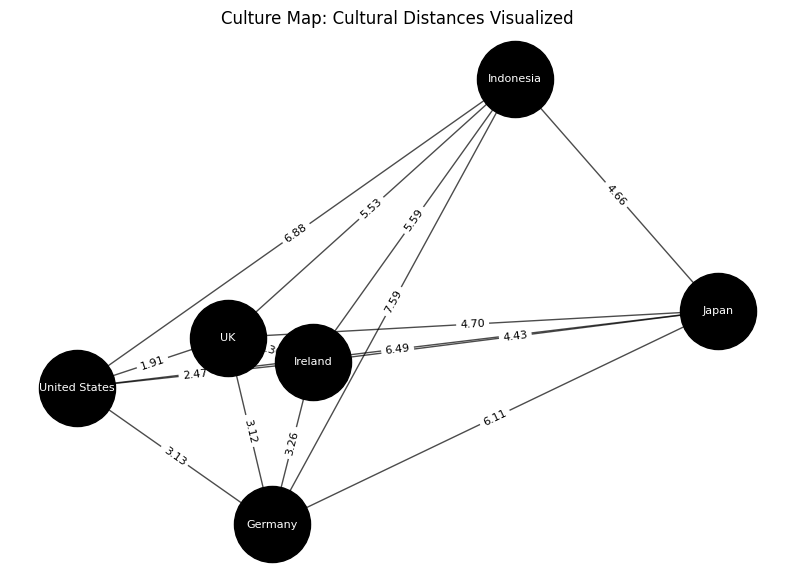

<Figure size 640x480 with 0 Axes>

In [168]:
# Load JSON data
with open("culture_map_data.json", "r") as f:
    culture_map_data = json.load(f)
# Calculate distances
distance_df = calculate_scaled_euclidean_distances(culture_map_data)
# Selected countries
#selected_countries = ["Germany", "Great Britain", "Indonesia", "Ireland", "Japan", "U.S.A."]
selected_countries = ["Germany", "UK", "Indonesia", "Ireland", "Japan", "United States"]

# Visualize the network
visualize_country_network(distance_df, selected_countries, title="Culture Map: Cultural Distances Visualized")

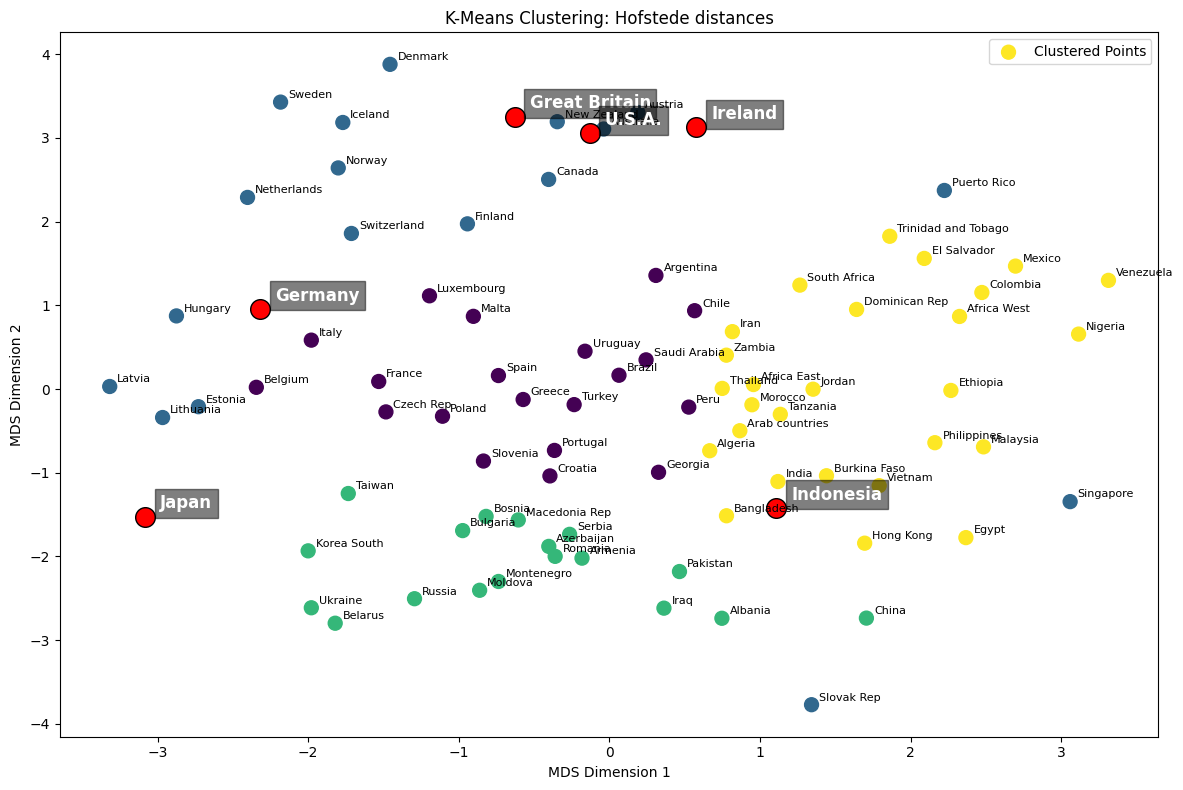

In [169]:
# Load JSON data
with open("hofstede_data.json", "r") as f:
    hofstede_data = json.load(f)

# Calculate distances
distance_df = calculate_scaled_euclidean_distances(hofstede_data)

# List of countries to highlight
highlight_countries = ["Germany", "Great Britain", "Japan", "U.S.A.", "Indonesia", "Ireland"]

# Plot K-Means clustering with highlighted countries
plot_kmeans_with_highlight(distance_df, highlight_countries, n_clusters=4, title="K-Means Clustering: Hofstede distances")

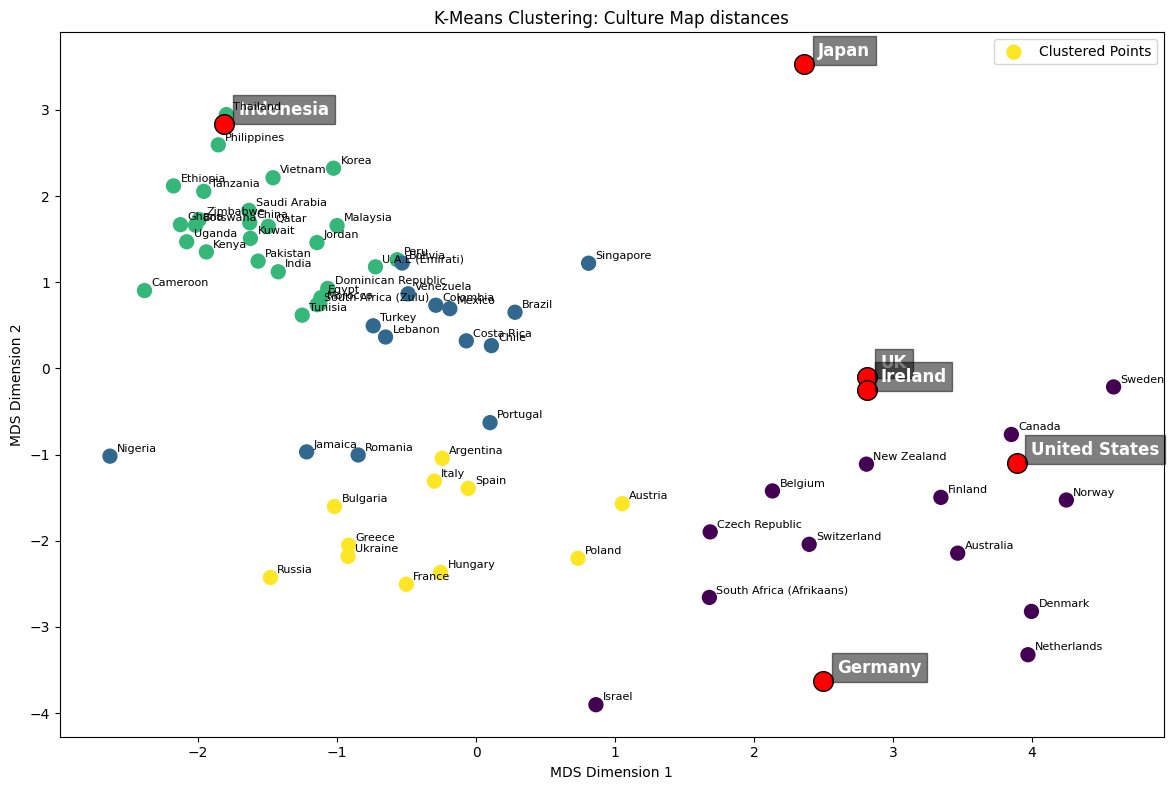

In [170]:
# Calculate distances
distance_df = calculate_scaled_euclidean_distances(culture_data)

# List of countries to highlight
highlight_countries = ["Germany", "UK", "Japan", "United States", "Indonesia", "Ireland"]

# Plot K-Means clustering with highlighted countries
plot_kmeans_with_highlight(distance_df, highlight_countries, n_clusters=4, title="K-Means Clustering: Culture Map distances")